In this notebook we will fine tune BERT Transformer model from Hugging Face on the custom dataset for multi-class classification using the Toxic comments dataset.

In [1]:
%%capture
!pip install transformers

In [2]:
import pandas as pd
import torch
import numpy as np
import re
import string
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv("/content/drive/MyDrive/toxic_comments_train.csv")
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
len(data)

159571

Let's do a basic pre-processing of the comment text

In [6]:
def clean_text(text):
    '''Remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    
    #pattern = [zero or more character]
    text = re.sub('\[.*?\]', '', text)
    
    #pattern = with or without(http),://, one or more non-white space character, OR www, .,one or more non-white space character
    text = re.sub('https?://\S+|www\.\S+', '', text)
    
    #pattern = <, zero or more characters, >, (one or more occurance of >)
    text = re.sub('<.*?>+', '', text)
    
    #pattern = any punctionation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    #pattern = any new line
    text = re.sub('\n', ' ', text)
    
    #pattern = any from[a-zA-Z0-9_], any from[0-9], any from [a-zA-Z0-9_]
    text = re.sub('\w*\d\w*', '', text)
    
    return text

data['comment_text'] = data['comment_text'].apply(clean_text)

In [7]:
# Let's check out first five comments

for text in data['comment_text'][0:5]:
  print(text, '\n')

Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They werent vandalisms just closure on some GAs after I voted at New York Dolls FAC And please dont remove the template from the talk page since Im retired  

Daww He matches this background colour Im seemingly stuck with Thanks  talk  January   UTC 

Hey man Im really not trying to edit war Its just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page He seems to care more about the formatting than the actual info 

 More I cant make any real suggestions on improvement  I wondered if the section statistics should be later on or a subsection of types of accidents  I think the references may need tidying so that they are all in the exact same format ie date format etc I can do that later on if noone else does first  if you have any preferences for formatting style on references or want to do it yourself please let me know  There appears to be

clean            143346
toxic             15294
severe_toxic       1595
obscene            8449
threat              478
insult             7877
identity_hate      1405
dtype: int64

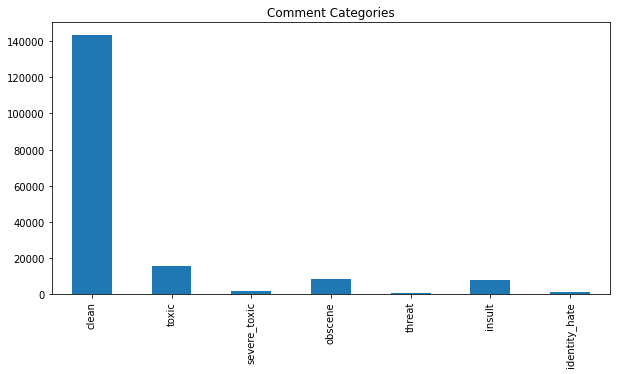

In [8]:
data['clean'] = data['toxic']+data['severe_toxic']+data['obscene']+data['threat']+data['insult']+data['identity_hate']

# We will change the value to 1 (meaning non toxic) if the value is 0 and set it to 0 for all other cases
data['clean'] = data['clean'].apply(lambda x: 1 if x==0 else 0)

data[['clean','toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum().plot.bar(figsize=(10,5),
                                                                                                           title='Comment Categories')
data[['clean','toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()

We will try to use around 1000 comments from each category to create a balanced dataset, since 'threat' category has less than 1000 comments available so we shall use all that are available (478) only, and we will use higher quantity for clean comments.

In [9]:
categories = [cat for cat in data.columns if cat not in ('id','comment_text','clean')]

data_balanced = data[data['clean']==1].sample(3000)

for category in categories:

  temp = data[data[category]==1]
  if len(temp)<1000:
    data_balanced = pd.concat([data_balanced, temp], axis=0)
  else:
    data_balanced = pd.concat([data_balanced, temp.sample(1000)], axis=0)

data = data_balanced.drop_duplicates()

del temp, data_balanced
print(data.shape)

(7460, 9)


clean            3000
toxic            4237
severe_toxic     1257
obscene          3341
threat            478
insult           3271
identity_hate    1141
dtype: int64

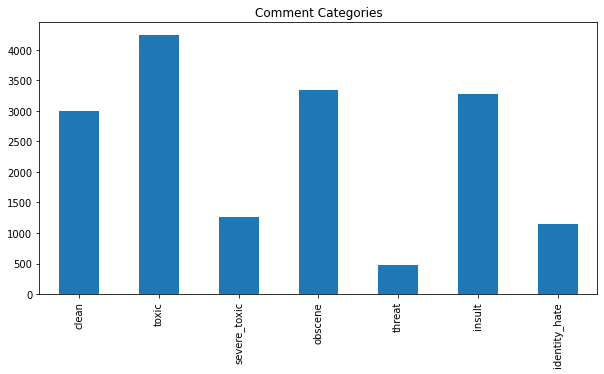

In [10]:
data[['clean','toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum().plot.bar(figsize=(10,5),
                                                                                                           title='Comment Categories')
data[['clean','toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()

This looks fine because there are many cases where a comment falls under multiple categories, therefore some categories have count greater than 1000.

In [11]:
# Splitting the data into train, validation and test sets

data = data.sample(frac=1, random_state=40)
n = len(data)

train = data[0:int(0.7*len(data))]
val = data[int(0.7*len(data)):int(0.85*len(data))]
test = data[int(0.85*len(data)):]

X_train = list(train['comment_text'])
categories = train[['clean','toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].to_numpy()
y_train = [list(label) for label in categories]

X_val = list(val['comment_text'])
categories = val[['clean','toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].to_numpy()
y_val = [list(label) for label in categories]

X_test = list(test['comment_text'])
categories = test[['clean','toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].to_numpy()
y_test = [list(label) for label in categories]

Now let's define the Dataset class

In [12]:
# Creating the tokenizer object. Using bert-base-cased since I believe comments in all-caps could have a distinct meaning
checkpoint = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(checkpoint)

class Dataset(torch.utils.data.Dataset):

    def __init__(self, X, y):

        self.labels = y
        self.texts = [tokenizer(text, 
                                padding='max_length', 
                                max_length = 512, 
                                truncation=True,
                                return_tensors="pt") for text in X]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        texts = self.texts[idx]
        label = np.array(self.labels[idx])
        return texts, label

Now let's define the BERT Classifier

In [13]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.4):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 7)  # Since we have 7 classes in the Label
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):

        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)
        return final_layer

Now let's create a training function to train the model

In [14]:
def loss(outputs, targets):
  return torch.nn.BCEWithLogitsLoss()(outputs, targets)

def accuracy(outputs, targets):
  
  preds = outputs.argmax(dim=1)
  score = 0
  for i, labels in enumerate(targets):
    if labels[preds[i]] == 1:
      score+=1

  return score/len(targets)

def plot_graphs(epoch_train_acc, epoch_train_loss, epoch_val_acc, epoch_val_loss):

  epoch_count = range(len(epoch_train_loss))

  plt.figure(figsize=(9,6))
  plt.plot(epoch_count, epoch_train_loss, label="Train loss")
  plt.plot(epoch_count, epoch_val_loss, label="Test loss")
  plt.title("Training and Validation Loss Curves")
  plt.xlabel("Epochs")
  plt.legend();

  plt.figure(figsize=(9,6))
  plt.plot(epoch_count, epoch_train_acc, label="Train accuracy")
  plt.plot(epoch_count, epoch_val_acc, label="Test accuracy")
  plt.title("Training and Validation Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend();


def train(model, X_train, y_train, X_val, y_val, learning_rate, epochs):

  train = Dataset(X_train, y_train)
  val = Dataset(X_val, y_val)

  train_dataloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
  val_dataloader = torch.utils.data.DataLoader(val, batch_size=16)  

  optimizer = Adam(model.parameters(), lr=learning_rate)

  cuda_available = torch.cuda.is_available()
  device = torch.device("cuda" if cuda_available else "cpu")    

  if cuda_available:
    model = model.cuda()

  epoch_train_loss = []
  epoch_val_loss = []
  epoch_train_acc = []
  epoch_val_acc = []

  for epoch_num in range(epochs):
    
    model.train()

    total_loss_train = 0
    total_batches_train = 0
    total_acc_train = 0

    for train_input, train_label in tqdm(train_dataloader):
      
      train_label = train_label.to(device, dtype=torch.float)
      attention_mask = train_input['attention_mask'].to(device, dtype=torch.long)
      input_ids = train_input['input_ids'].squeeze(1).to(device, dtype=torch.long)

      output = model(input_ids, attention_mask)

      batch_loss = loss(output, train_label)
      total_loss_train += batch_loss.item()

      batch_acc = accuracy(output, train_label)
      total_acc_train += batch_acc

      total_batches_train += 1

      model.zero_grad()
      batch_loss.backward()
      optimizer.step()
    
    avg_loss_train = total_loss_train / total_batches_train
    avg_acc_train = total_acc_train / total_batches_train
    
    model.eval()

    total_loss_val = 0
    total_batches_val = 0
    total_acc_val = 0
    
    with torch.no_grad():

      for val_input, val_label in val_dataloader:

        val_label = val_label.to(device, dtype=torch.float)
        attention_mask = val_input['attention_mask'].to(device, dtype=torch.long)
        input_ids = val_input['input_ids'].squeeze(1).to(device, dtype=torch.long)

        output = model(input_ids, attention_mask)

        batch_loss = loss(output, val_label)
        total_loss_val += batch_loss.item()

        batch_acc = accuracy(output, val_label)
        total_acc_val += batch_acc

        total_batches_val += 1
                
    avg_loss_val = total_loss_val / total_batches_val
    avg_acc_val = total_acc_val / total_batches_val

    print(f'Epochs: {epoch_num + 1} | Train Loss: {avg_loss_train:.3f} |  Train Accuracy: {avg_acc_train:.3f} | Validation Loss: {avg_loss_val:.3f} | Validation Accuracy: {avg_acc_val:.3f}')
    
    epoch_train_loss.append(avg_loss_train)
    epoch_val_loss.append(avg_loss_val)
    epoch_train_acc.append(avg_acc_train)
    epoch_val_acc.append(avg_acc_val)
  
  plot_graphs(epoch_train_acc, epoch_train_loss, epoch_val_acc, epoch_val_loss)


Let's train the model now

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 327/327 [07:55<00:00,  1.45s/it]


Epochs: 1 | Train Loss: 0.717 |  Train Accuracy: 0.490 | Validation Loss: 0.681 | Validation Accuracy: 0.744


100%|██████████| 327/327 [08:15<00:00,  1.51s/it]


Epochs: 2 | Train Loss: 0.685 |  Train Accuracy: 0.658 | Validation Loss: 0.671 | Validation Accuracy: 0.765


100%|██████████| 327/327 [08:14<00:00,  1.51s/it]


Epochs: 3 | Train Loss: 0.666 |  Train Accuracy: 0.762 | Validation Loss: 0.647 | Validation Accuracy: 0.797


100%|██████████| 327/327 [08:15<00:00,  1.51s/it]


Epochs: 4 | Train Loss: 0.617 |  Train Accuracy: 0.864 | Validation Loss: 0.599 | Validation Accuracy: 0.892


100%|██████████| 327/327 [08:15<00:00,  1.51s/it]


Epochs: 5 | Train Loss: 0.594 |  Train Accuracy: 0.903 | Validation Loss: 0.589 | Validation Accuracy: 0.909


100%|██████████| 327/327 [08:15<00:00,  1.51s/it]


Epochs: 6 | Train Loss: 0.586 |  Train Accuracy: 0.916 | Validation Loss: 0.585 | Validation Accuracy: 0.902


100%|██████████| 327/327 [08:14<00:00,  1.51s/it]


Epochs: 7 | Train Loss: 0.580 |  Train Accuracy: 0.927 | Validation Loss: 0.582 | Validation Accuracy: 0.911


100%|██████████| 327/327 [08:14<00:00,  1.51s/it]


Epochs: 8 | Train Loss: 0.575 |  Train Accuracy: 0.928 | Validation Loss: 0.580 | Validation Accuracy: 0.909


100%|██████████| 327/327 [08:14<00:00,  1.51s/it]


Epochs: 9 | Train Loss: 0.573 |  Train Accuracy: 0.932 | Validation Loss: 0.581 | Validation Accuracy: 0.912


100%|██████████| 327/327 [08:14<00:00,  1.51s/it]


Epochs: 10 | Train Loss: 0.570 |  Train Accuracy: 0.935 | Validation Loss: 0.578 | Validation Accuracy: 0.914


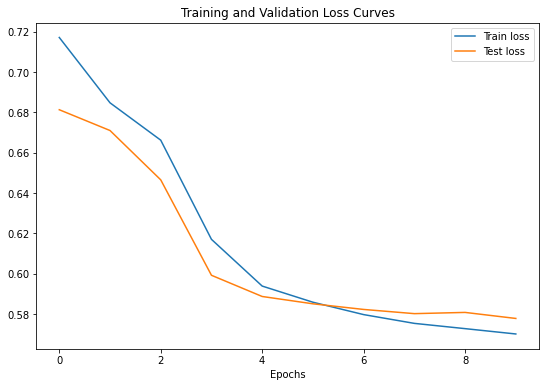

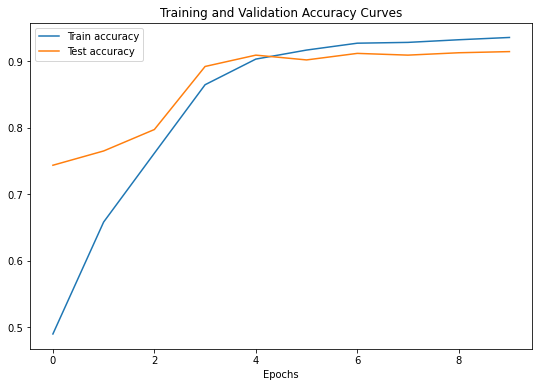

In [15]:
EPOCHS = 10
LR = 1e-6
bert_model = BertClassifier()        
train(bert_model, X_train, y_train, X_val, y_val, LR, EPOCHS)

In [16]:
# Let's create an evaluation function

def evaluate(model, X_test, y_test):

    test = Dataset(X_test, y_test)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=16)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        model = model.cuda()

    model.eval()

    total_loss_test = 0
    total_batches_test = 0
    total_acc_test = 0

    with torch.no_grad():
        
      for test_input, test_label in test_dataloader:
          
        test_label = test_label.to(device, dtype=torch.float)
        attention_mask = test_input['attention_mask'].to(device, dtype=torch.long)
        input_ids = test_input['input_ids'].squeeze(1).to(device, dtype=torch.long)

        output = model(input_ids, attention_mask)
        
        batch_loss = loss(output, test_label)
        total_loss_test += batch_loss.item()

        batch_acc = accuracy(output, test_label)
        total_acc_test += batch_acc
        
        total_batches_test += 1
            
    avg_loss_test = total_loss_test / total_batches_test
    avg_acc_test = total_acc_test / total_batches_test

    print(f'Test Loss: {avg_loss_test:.3f} | Test Accuracy: {avg_acc_test:.3f}')
    return avg_loss_test, avg_acc_test


In [17]:
# Let's evaluate the model on the test set now

evaluate(bert_model, X_test, y_test)

Test Loss: 0.581 | Test Accuracy: 0.917


(0.5810321169240135, 0.916904761904762)

Let's try out the model with some sample comments

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sample = ["You are stupid enough to go there alone.", 
          "I am going home", 
          "fuck you asshole!!", 
          "I love you more everyday.", 
          "I loved you but not anymore since I am now over you, so kindly leave me alone."
]

input = tokenizer(sample, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")

attention_mask = input['attention_mask'].to(device)
input_ids = input['input_ids'].squeeze(1).to(device)
logits = bert_model(input_ids, attention_mask)

# Printing the model output logits
print(['clean','toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
print(logits)

['clean', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
tensor([[0.0000, 1.1563, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.1476, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 3.7031, 0.0000, 3.5952, 0.0000, 2.3132, 0.0000],
        [1.2610, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.2768, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<ReluBackward0>)


In [41]:
# Let's convert the model output logits into probabilites by passing them through the Softmax function
predictions = torch.nn.functional.softmax(logits, dim=-1)

labels = ['clean','toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
preds = predictions.detach().cpu().numpy()

for i, probs in enumerate(preds):
  print("\nComment:", sample[i])
  print("Prediction:", labels[np.argmax(probs)])
  print("Probability:", probs[np.argmax(probs)])

pred_df = pd.DataFrame(preds, columns=labels)
pred_df.insert(0, "Comment", sample)
pred_df


Comment: You are stupid enough to go there alone.
Prediction: toxic
Probability: 0.34627286

Comment: I am going home
Prediction: clean
Probability: 0.34431463

Comment: fuck you asshole!!
Prediction: toxic
Probability: 0.4453473

Comment: I love you more everyday.
Prediction: clean
Probability: 0.37032914

Comment: I loved you but not anymore since I am now over you, so kindly leave me alone.
Prediction: clean
Probability: 0.37402582


,Comment,clean,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,You are stupid enough to go there alone.,0.108955,0.346273,0.108955,0.108955,0.108955,0.108955,0.108955
1,I am going home,0.344315,0.109281,0.109281,0.109281,0.109281,0.109281,0.109281
2,fuck you asshole!!,0.010977,0.445347,0.010977,0.399808,0.010977,0.110937,0.010977
3,I love you more everyday.,0.370329,0.104945,0.104945,0.104945,0.104945,0.104945,0.104945
4,I loved you but not anymore since I am now ove...,0.374026,0.104329,0.104329,0.104329,0.104329,0.104329,0.104329


In [42]:
# Let's save the model's state_dict

PATH = '/content/drive/MyDrive/toxic_comm_multi_classifier.pt'
torch.save(bert_model.state_dict(), PATH)